In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [78]:
features = pd.read_csv('features.csv')
sales = pd.read_csv('sales.csv')
stores = pd.read_csv('stores.csv')

## Merge the datasets and get some useful columns

In [79]:
sales['Year'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y').dt.year

sales['n_of_Week'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y').dt.week

sales['IsHoliday'] = sales['IsHoliday'].astype('int64')

sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,n_of_Week
0,1,1,05/02/2010,24924.50,0,2010,5
1,1,1,12/02/2010,46039.49,1,2010,6
2,1,1,19/02/2010,41595.55,0,2010,7
3,1,1,26/02/2010,19403.54,0,2010,8
4,1,1,05/03/2010,21827.90,0,2010,9


#### Stores dataset

In [80]:
#Size and type of store can be useful for predicting the number of sales, so we might as well merge them in to the dataset
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [81]:
sales = pd.merge(sales,stores[['Store','Type','Size']])

#### Features dataset

In [82]:
features['Year'] = pd.to_datetime(features['Date'], format='%d/%m/%Y').dt.year
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,2010
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,2010
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,2010
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,2010


In [83]:
#These features might also help to improve the accuracy of our model, so we merge them into the sales dataset
sales = pd.merge(sales, features[['Store','Date','Unemployment','Fuel_Price','Temperature','CPI',
                                 'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']])
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,n_of_Week,Type,Size,Unemployment,Fuel_Price,Temperature,CPI,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
0,1,1,05/02/2010,24924.50,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,NaN,NaN,NaN,NaN,NaN
1,1,2,05/02/2010,50605.27,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,NaN,NaN,NaN,NaN,NaN
2,1,3,05/02/2010,13740.12,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,NaN,NaN,NaN,NaN,NaN
3,1,4,05/02/2010,39954.04,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,NaN,NaN,NaN,NaN,NaN
4,1,5,05/02/2010,32229.38,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,NaN,NaN,NaN,NaN,NaN


In [84]:
#If there is no markdown, then the value of the markdown should be 0.
markdowns = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

sales[markdowns] = sales[markdowns].fillna(0)

sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,n_of_Week,Type,Size,Unemployment,Fuel_Price,Temperature,CPI,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
0,1,1,05/02/2010,24924.50,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0
1,1,2,05/02/2010,50605.27,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0
2,1,3,05/02/2010,13740.12,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0
3,1,4,05/02/2010,39954.04,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0
4,1,5,05/02/2010,32229.38,0,2010,5,A,151315,8.106,2.572,42.31,211.096358,0.0,0.0,0.0,0.0,0.0


## Analysis on columns

In [85]:
from scipy.stats import pearsonr

#### Unemployment

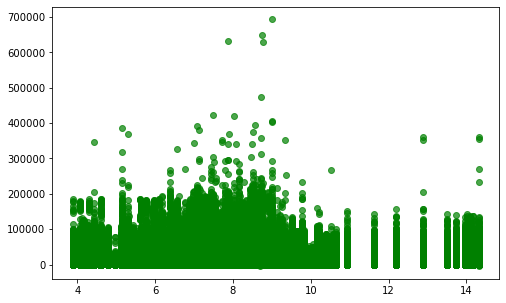

In [86]:
fig = plt.figure(figsize=(8,5))

plt.scatter(sales['Unemployment'],sales['Weekly_Sales'], alpha=0.7, color='g')

In [87]:
corr, _ = pearsonr(sales['Unemployment'], sales['Weekly_Sales'])
print(f'Pearsons correlation: {corr:.3f}')

Pearsons correlation: -0.026


In [88]:
sales.drop(columns=['Unemployment'], inplace=True)

#### Fuel price

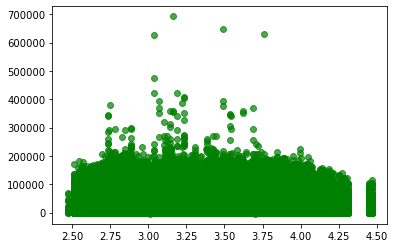

In [89]:
plt.scatter(sales['Fuel_Price'],sales['Weekly_Sales'], alpha=0.7, color='g')

In [90]:
corr, _ = pearsonr(sales['Fuel_Price'], sales['Weekly_Sales'])
print(f'Pearsons correlation: {corr:.3f}')

Pearsons correlation: -0.000


In [91]:
sales.drop(columns=['Fuel_Price'], inplace=True)

#### CPI

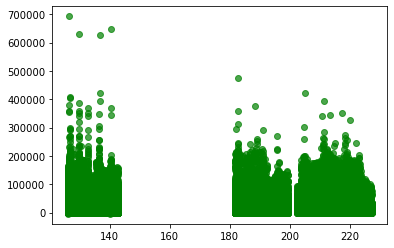

In [92]:
plt.scatter(sales['CPI'],sales['Weekly_Sales'], alpha=0.7, color='g')

In [93]:
corr, _ = pearsonr(sales['CPI'], sales['Weekly_Sales'])
print(f'Pearsons correlation: {corr:.3f}')

Pearsons correlation: -0.021


In [94]:
sales.drop(columns=['CPI'], inplace=True)

#### Temperature

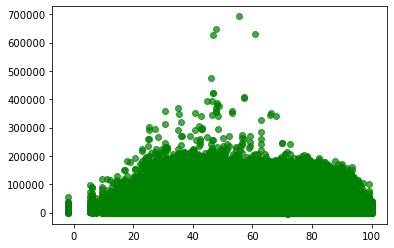

In [95]:
plt.scatter(sales['Temperature'],sales['Weekly_Sales'], alpha=0.7, color='g')

In [96]:
corr, _ = pearsonr(sales['Temperature'], sales['Weekly_Sales'])
print(f'Pearsons correlation: {corr:.3f}')

Pearsons correlation: -0.002


In [97]:
sales.drop(columns=['Temperature'], inplace=True)

#### Markdowns

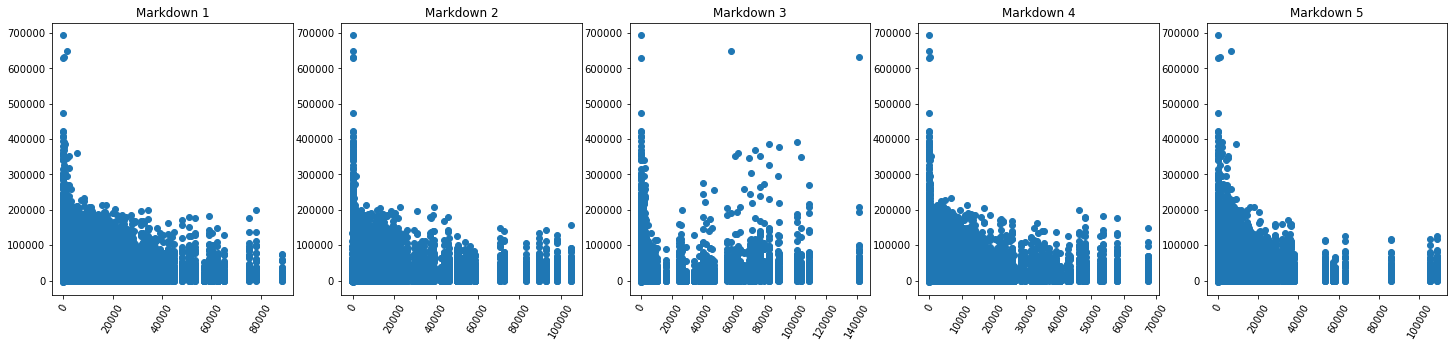

In [98]:
fig, ax = plt.subplots(ncols=5, figsize=(25, 5))

for i in range(5):
    ax[i].scatter(sales[f'MarkDown{i+1}'], sales['Weekly_Sales'])
    ax[i].tick_params(axis='x', labelrotation=60)

    ax[i].set_title(f'Markdown {i+1}')

plt.show()

In [99]:
for i in range(5):
    md = f'MarkDown{i+1}'
    corr, _ = pearsonr(sales[md], sales['Weekly_Sales'])
    print(f'Pearsons correlation for {md}: {corr:.3f}')

Pearsons correlation for MarkDown1: 0.047
Pearsons correlation for MarkDown2: 0.021
Pearsons correlation for MarkDown3: 0.039
Pearsons correlation for MarkDown4: 0.037
Pearsons correlation for MarkDown5: 0.050


## Plot weekly sales for each year

In [34]:
year_list = []

for year in sales['Year'].unique():
    sales_per_year = sales[sales['Year']==year]['Weekly_Sales'].groupby(sales['n_of_Week']).sum().reset_index()
    year_list.append(sales_per_year)

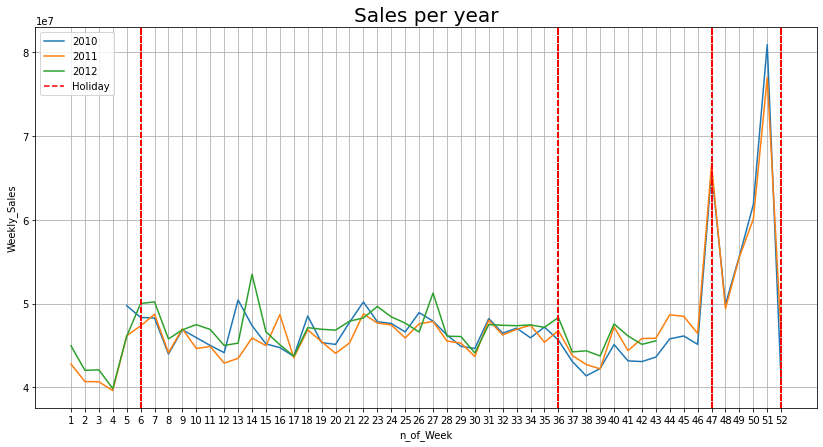

In [47]:
plt.figure(figsize=(14,7))

for i in range(len(year_list)):
    sns.lineplot(x = 'n_of_Week', y = 'Weekly_Sales', data = year_list[i])

plt.title('Sales per year', fontsize=20)
plt.grid()
plt.xticks(np.arange(1,53,1))

holiday = sales['n_of_Week'].values[(sales['IsHoliday']==1)]

for holiday_week in holiday:
    plt.axvline(holiday_week, color='red',linestyle='--')

labels = [year for year in sales['Year'].unique()]
labels.append('Holiday')

plt.legend(labels = labels)
plt.show()

## Encode 'Type' column

In [100]:
dummies_cols = pd.get_dummies(sales['Type'], prefix = 'Type')

sales.drop('Type', inplace=True, axis=1)

sales = sales.join(dummies_cols)

## Predict the department-wide sales for each store for the following year

### Split data 

In [101]:
y = sales['Weekly_Sales']
#We dont need the date so we drop it
x = sales.drop(['Date','Weekly_Sales'], axis=1)

In [102]:
import pickle

In [103]:
pickle_out = open('x.pickle','wb')
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle','wb')
pickle.dump(y, pickle_out)
pickle_out.close()

In [104]:
#Load x and y

pickle_in = open('x.pickle','rb')
x = pickle.load(pickle_in)

pickle_in = open('y.pickle','rb')
y = pickle.load(pickle_in)

### Create the model and evaluate it

In [106]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [107]:
model = XGBRegressor(n_estimators = 50, max_depth = 25)

pipeline = Pipeline(steps=[('m',model)])

In [108]:
n_scores = -1*cross_val_score(pipeline, x, y, scoring='neg_mean_absolute_error', cv=5)

In [109]:
print(f'MAE scores: {np.mean(n_scores):.3f}')

MAE scores: 6175.597
